**Target :**
Achieve Model accuracy 99.4 at least 5 times in 15 epochs

**Constraint :**

Use less than 10 k paramter
Use less than 15 epochs 


**Parameters used :**9862

**Technique :**
Technique same as s5_Drill_02.ipynb

**Extra Added :**

Image Augmentation (7 degree + and -)

**Result :**
Best Train Accuracy :99.32

Best Test Accuracy :99.49

#TARGET ACHIEVED


In [1]:
# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.4213)
 - std: tensor(0.0889)
 - var: tensor(0.0079)
torch.Size([128, 1, 28, 28])
torch.Size([128])


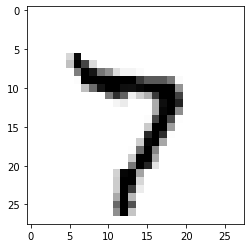

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

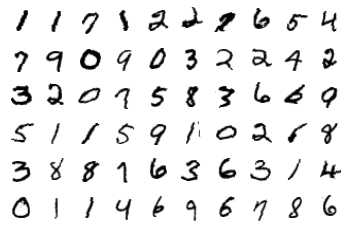

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [8]:

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=12,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(12),
        nn.ReLU(),
        #nn.Dropout(0.1),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 18,out_channels = 9,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=9,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=18,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 18, 24, 24]           1,944
       BatchNorm2d-5           [-1, 18, 24, 24]              36
              ReLU-6           [-1, 18, 24, 24]               0
            Conv2d-7            [-1, 9, 24, 24]             162
         MaxPool2d-8            [-1, 9, 12, 12]               0
            Conv2d-9           [-1, 18, 10, 10]           1,458
      BatchNorm2d-10           [-1, 18, 10, 10]              36
             ReLU-11           [-1, 18, 10, 10]               0
           Conv2d-12             [-1, 18, 8, 8]           2,916
      BatchNorm2d-13             [-1, 18, 8, 8]              36
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.09478175640106201 Batch_id=468 Accuracy=85.33: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0988, Accuracy: 9789/10000 (97.89%)

EPOCH: 2


Loss=0.1780279278755188 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.06336981803178787 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.02758990414440632 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.07143096625804901 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.02272868901491165 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.059960704296827316 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.02708580158650875 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.020259041339159012 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.019298430532217026 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.021079523488879204 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.021750621497631073 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.013718762435019016 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.06555365771055222 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.020444391295313835 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



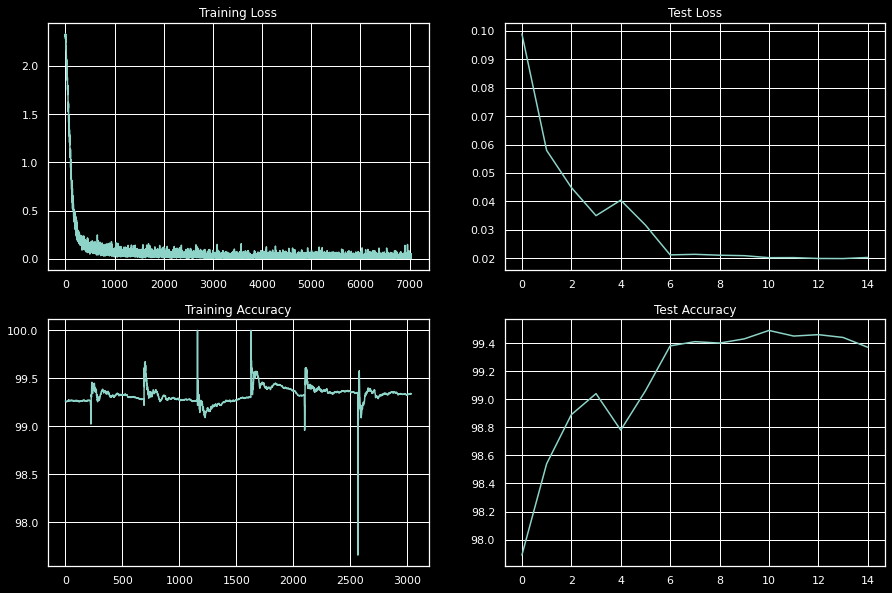

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()